# Energy spectra example

This notebook is a minimal example of computing energy spectra from PIV data. 

## 0 Packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1 Utility functions

In [1]:
def compute_energy_density(pivData, d=25*0.33, MPP=0.33):
    """
    Compute kinetic energy density in k space from piv data. The unit of the return value is [velocity] * [length],
    where [velocity] is the unit of pivData, and [length] is the unit of sample_spacing parameter.
    Note, the default value of sampling_spacing does not have any significance. It is just the most convenient value for my first application,
    and should be set with caution when a different magnification and PIV are used.

    Args:
    pivData -- 2D piv data, DataFrame of x, y, u, v
    d -- sample spacing, in unit of microns
    MPP -- microns per pixel

    Returns:
    E -- kinetic energy field in wavenumber (k) space

    Test:
    pivData = pd.read_csv(r'E:\moreData\08032020\piv_imseq\01\3370-3371.csv')
    compute_energy_density(pivData)

    Edit:
    11020202 -- Add parameter sample_spacing, the distance between adjacent velocity (or data in general.
                The spacing is used to rescale the DFT so that it has a unit of [velocity] * [length].
                In numpy.fft, the standard fft function is defined as

                A_k = \sum\limits^{n-1}_{m=0} a_m \exp \left[ -2\pi i \frac{mk}{n} \right]

                The unit of this Fourier Transform $A_k$ is clearly the same as $a_m$.
                In order to get unit [velocity] * [length], and to make transform result consistent at different data density,
                I introduce sample_spacing $d$ as a modifier of the DFT. After this modification, the energy spectrum computed
                at various step size (of PIV) should give quantitatively similar results.
    11042020 -- Replace the (* sample_spacing * sample_spacing) after v_fft with ( / row / col). This overwrites the edit I did on 11022020.
    11112020 -- removed ( / row / col), add the area constant in energy_spectrum() function.
                Details can be found in https://zloverty.github.io/research/DF/blogs/energy_spectrum_2_methods_11112020.html
    11302020 -- 1) Convert unit of velocity, add optional arg MPP (microns per pixel)
                2) Add * d * d to both velocity FFT's to account for the missing length in default FFT algorithm
                3) The energy spectrum calculated by this function shows a factor of ~3 difference when comparing \int E(k) dk with v**2.sum()/2
    """

    row = len(pivData.y.drop_duplicates())
    col = len(pivData.x.drop_duplicates())
    U = np.array(pivData.u).reshape((row, col)) * MPP
    V = np.array(pivData.v).reshape((row, col)) * MPP

    u_fft = np.fft.fft2(U) * d * d
    v_fft = np.fft.fft2(V) * d * d

    E = (u_fft * u_fft.conjugate() + v_fft * v_fft.conjugate()) / 2

    return E

def compute_wavenumber_field(shape, d):
    """
    Compute the wave number field Kx and Ky, and magnitude field k.
    Note that this function works for even higher dimensional shape.

    Args:
    shape -- shape of the velocity field and velocity fft field, tuple
    d -- sample spacing. This is the distance between adjacent samples, for example, velocities in PIV.
        The resulting frequency space has the unit which is inverse of the unit of d. The preferred unit of d is um.

    Returns:
    k -- wavenumber magnitude field
    K -- wavenumber fields in given dimensions

    Edit:
    12022020 -- multiply 2pi to the wavenumber to account for the built-in 2pi in the fft method.
                This factor leads to a difference in the magnitude of 1D energy spectra.
                Note: the dimensionless wavenumber should remain unchanged.

    Test:
    shape = (5, 5)
    k, K = compute_wavenumber_field(shape, 0.2)
    """

    for num, length in enumerate(shape):
        kx = np.fft.fftfreq(length, d=d)
        if num == 0:
            k = (kx,)
        else:
            k += (kx,)

    K = np.meshgrid(*k, indexing='ij')

    for num, k1 in enumerate(K):
        if num == 0:
            ksq = k1 ** 2
        else:
            ksq += k1 ** 2

    k_mag = ksq ** 0.5 * 2 * np.pi

    return k_mag, K

def energy_spectrum(pivData, d=25*0.33):
    """
    Compute energy spectrum (E vs k) from pivData.

    Args:
    pivData -- piv data
    d -- sample spacing. This is the distance between adjacent samples, for example, velocities in PIV.
        The resulting frequency space has the unit which is inverse of the unit of d. The default unit of d is um.

    Returns:
    es -- energy spectrum, DataFrame (k, E)

    Edit:
    10192020 -- add argument d as sample spacing
    11112020 -- add area constant, see details in https://zloverty.github.io/research/DF/blogs/energy_spectrum_2_methods_11112020.html
    11302020 -- 1) The energy spectrum calculated by this function shows a factor of ~3 difference when comparing \int E(k) dk with v**2.sum()/2
    """

    row = len(pivData.y.drop_duplicates())
    col = len(pivData.x.drop_duplicates())

    E = compute_energy_density(pivData, d) / (row * d * col * d)
    k, K = compute_wavenumber_field(E.shape, d)

    ind = np.argsort(k.flatten())
    k_plot = k.flatten()[ind]
    E_plot = E.real.flatten()[ind]

    es = pd.DataFrame(data={'k': k_plot, 'E': E_plot})

    return es

def xy_bin(xo, yo, n=100, mode='log', bins=None):
    """
    Bin x, y data on log or linear scale

    Args:
    xo -- input x
    yo -- input y
    n -- points after binning
    mode --
    bins -- set the bins to bin data together

    Returns:
    x -- binned x
    y -- means in bins

    Edit:
    11042020 -- Change function name to xy_bin, to incorporate the mode parameter, so that the function can do both log space binning and linear space binning.
    11172020 -- add bins kwarg, allow user to enter custom bins.
    Dec 16, 2021 -- fix divided by 0 issue.
    """
    assert(len(xo)==len(yo))
    if bins is None:
        if mode == 'log':
            x = np.logspace(np.log10(xo[xo>0].min()), np.log10(xo.max()), n+1)
        elif mode == 'lin':
            x = np.linspace(xo.min(), xo.max(), n+1)
    else:
        x = np.sort(bins)
    top = np.histogram(xo, x, weights=yo)[0]
    bot = np.histogram(xo, x)[0]
    ind = bot > 0
    xb = ((x[1:] + x[:-1]) / 2)[ind]
    yb = top[ind] / bot[ind]
    return xb, yb

## 2 Compute energy spectra

In [13]:
# load PIV data
pivData = pd.read_csv("piv-sample.csv")
# set constants
sample_spacing = 25 * 0.33 # PIV arrow spacing in micron
kb = 2 * np.pi / 3 # wavenumber corresponding to E. coli body length
# compute ES from PIV data
es = energy_spectrum(pivData, sample_spacing)
print("Note that all the E values are energy density in 2D, with unit um^4/s^2")
es.head()

Note that all the E values are energy density in 2D, with unit um^4/s^2


,k,E
0,0.00000,76737.142490
1,0.00952,685865.994884
2,0.00952,578950.112545
3,0.00952,578950.112545
4,0.00952,685865.994884


Text(0, 0.5, '$E^{2D}(k)$ (um$^4$/s$^2$)')

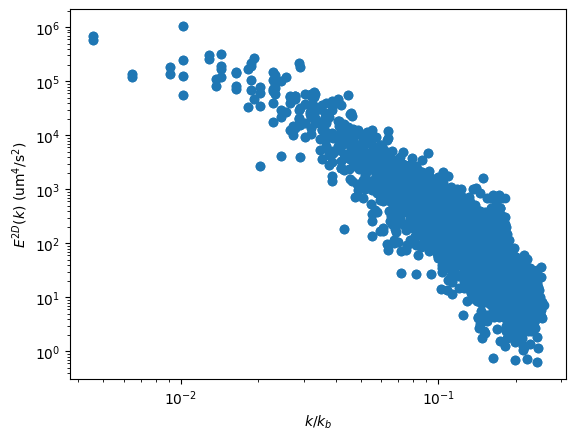

In [17]:
# plot "2D energy density"
plt.scatter(es.k/kb, es.E)
plt.loglog()
plt.xlabel("$k/k_b$")
plt.ylabel("$E^{2D}(k)$ (um$^4$/s$^2$)")

In [10]:
# bin data in radial direction, convert to 1D energy density, by multiplying corresponding circumference 
x, y = xy_bin(es.k, es.E) # binning the data so they are evenly distributed in log scale
y *= 2 * np.pi * x # convert 2D density to 1D density

Text(0, 0.5, '$E^{1D}(k)$ (um$^3$/s$^2$)')

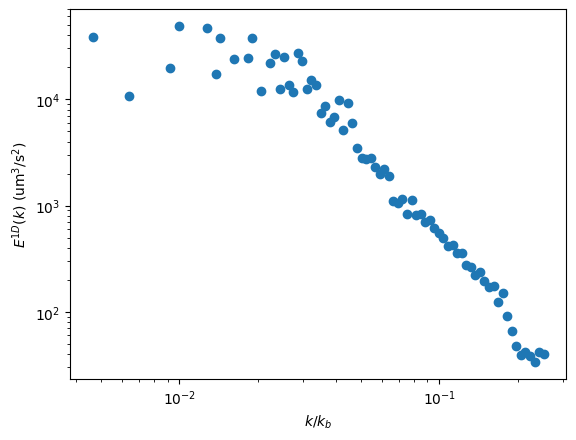

In [16]:
# plot "1-D energy density", aka energy spectra
plt.scatter(x/kb, y)
plt.loglog()
plt.xlabel("$k/k_b$")
plt.ylabel("$E^{1D}(k)$ (um$^3$/s$^2$)")